In [6]:
from utils import Candidate
from utils import Quadrant
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
import astropy.wcs as wcs 

import psf
import crowdsource_base

### Goal:
1. Do Dr. Knop's crowdsource on the reference image. Make sure the model and subtraction are much better.
2. Generate a reference csv file.
3. Based on the reference csv file, do Dr. Knop's crowdsource on another random image. Make sure the model and subtraction are much better.
4. Experiment with using gaussian vs. moffat psfs and toggling the refit_sky and other parameters on and off.

In [7]:
# Get the reference and test images

name = "DC21saaw"
radec = (270.31184, -28.77637)
c = Candidate(name, radec)
c.start()
iid = c.get_image_ids()
imref_fp, wref_fp = c.get_fp("c4d_210322_091756_ori") # Tuple of image and weight file
imfnames, wfnames = zip(*c.get_all_fps()) # List of tuples of image and weight files
c.close()

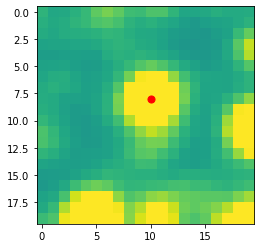

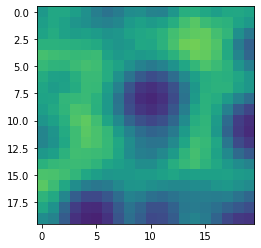

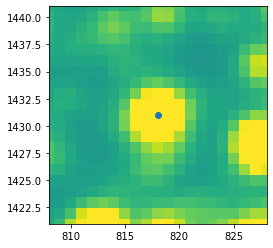

818.0390151691827 1430.9941707647922


In [8]:
# Look at the reference image
s = 10

radec = (270.31177, -28.776405) # Updated ra/dec manually

imhdul = fits.open(imref_fp) # get a file
weighthdul = fits.open(wref_fp)

q = Quadrant(imhdul, (2*s, 2*s)) # start a tile
# xy = q.get_xy_from_radec(np.array([[radec[0], radec[1]]])) # convert radec to pixel values
xrel, yrel = q.get_rel_xy((radec[0], radec[1]))


# PLOT QUADRANT IMAGE
subim, c = q.get_tile((radec[0], radec[1])) # Get the image centered on the int near radect

ymin, ymax, xmin, xmax = c
weight = np.flipud(weighthdul[1].data[c[2]:c[3], c[0]:c[1]])

plt.imshow(subim, vmin=-1600, vmax=1600)

#xrel, yrel = q.get_rel_pos(xy[0][0], xy[0][1]) # Get the relative x and y positions based on the top left corner of quadrant
# print(f"x, y = {xy} limits = {c} zrel, yrel = {xrel, yrel}")
plt.scatter(xrel, yrel, s=50, color = "red", alpha = 1) # plot the center and the x/y for ra/dec
plt.show()

# weight = weighthdul[1].data[ymin:ymax, xmin:xmax]
vmin, vmax = ZScaleInterval().get_limits(weighthdul[1].data)
plt.imshow(weight, vmin=vmin, vmax=vmax)
plt.show()

# JUST DO THE PLT XLIM THING
im = imhdul[1].data
r = np.array([[radec[0], radec[1]]])
xy = q.get_xy_from_radec(r)

x, y = xy[0][0], xy[0][1]

plt.imshow(im, vmin=-1600, vmax=1600)
plt.xlim(x-s, x+s)
plt.ylim(y-s, y+s)
plt.scatter(x, y)
plt.show()

print(x, y)

Fewer than 5 stars accepted in image, keeping original PSF
Extension None, iteration  1, found      9 sources;    0 close and    0 faint sources removed.
Fewer than 5 stars accepted in image, keeping original PSF
Extension None, iteration  2, found      1 sources;    0 close and    0 faint sources removed.
Fewer than 5 stars accepted in image, keeping original PSF
Extension None, iteration  3, found      1 sources;    0 close and    0 faint sources removed.
Fewer than 5 stars accepted in image, keeping original PSF
Extension None, iteration  4, found      0 sources;    0 close and    0 faint sources removed.
starting reference image


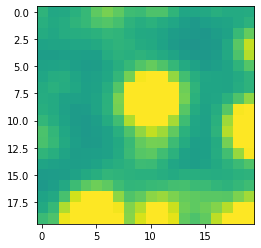

reference model image


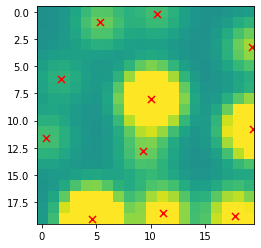

reference difference image


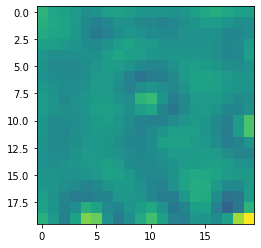

reference model image


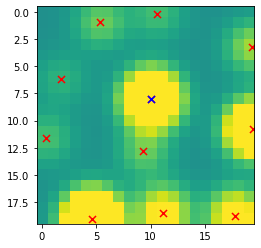

(270.31177, -28.776405) [[270.31093492 270.31111784 270.31138037 270.31152028 270.31183247
  270.31174373 270.31239321 270.31241102 270.31244928 270.31086943
  270.3119238 ]
 [-28.77605813 -28.77707382 -28.77579884 -28.77640325 -28.77570348
  -28.7770889  -28.77648532 -28.77697187 -28.77601061 -28.77643541
  -28.77635438]]


In [9]:
# Crowdsource on Reference Image

psf_ = psf.gaussian_psf(4, deriv=False) # get the psf stamps
psf_ = np.reshape(psf_, (19, 19)) # reshape the psf into the shape the SimplePSF object needs.
psf__ = psf.SimplePSF(psf_) # make a SimplePSF psf object with the stamps.
    
#CROWDSOURCE GET XS AND YS
pars = crowdsource_base.fit_im(subim, psf__, weight=weight, 
                           verbose=True, miniter=4, maxiter=10, 
                           refit_psf=True, derivcentroids=True, refit_sky=False) # Get the crowdsource fit (including sky subtraction).

print("starting reference image")
plt.imshow(subim, vmin=-1600, vmax=1600 )
plt.show()

print("reference model image")
plt.imshow(pars[1], vmin=-1600, vmax=1600 )
plt.scatter(pars[0]["y"], pars[0]["x"], s=50, color = "red", alpha = 1, marker = "x")
plt.show()

print("reference difference image")
plt.imshow(subim - pars[1], vmin=-1600, vmax=1600 )
plt.show()


# Transform xs and ys back

x = pars[0]["x"] + xmin
y = pars[0]["y"] + ymin

#print(x, y)
#print(c)

# x = pars[0]["x"]
# y = pars[0]["y"]
radecs = np.transpose(q.get_radec_from_xy(np.transpose(np.array([list(y), list(x)]))))

#print(radecs)
#print(radec)

im = imhdul[1].data

# Plot the original radec over this.
ws = wcs.WCS(imhdul[1].header)  # create a wcs object with the quadrant object's header
xy = ws.wcs_world2pix(np.array([[radec[0], radec[1]]]), 0)  # return the Ra/Dec positions as a numpy array

x = xy[0][0]
y = xy[0][1]
xrel = x - ymin
yrel = 2*s - (y - xmin) - 1



print("reference model image")
plt.imshow(pars[1], vmin=-1600, vmax=1600 )
plt.scatter(pars[0]["y"], pars[0]["x"], s=50, color = "red", alpha = 1, marker = "x")
plt.scatter(xrel, yrel, s=50, color = "blue", alpha = 1, marker = "x")
plt.show()

#print(xy, xrel, yrel, xmin, ymin)

print(radec, radecs)

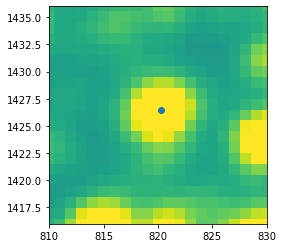

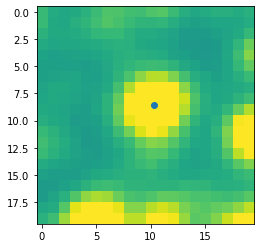

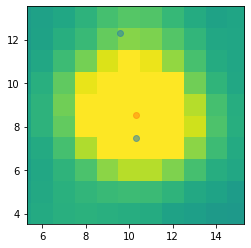

(270.31177, -28.776405) [[270.31093492 270.31111784 270.31138037 270.31152028 270.31183247
  270.31174373 270.31239321 270.31241102 270.31244928 270.31086943
  270.3119238 ]
 [-28.77605813 -28.77707382 -28.77579884 -28.77640325 -28.77570348
  -28.7770889  -28.77648532 -28.77697187 -28.77601061 -28.77643541
  -28.77635438]]
fluffy


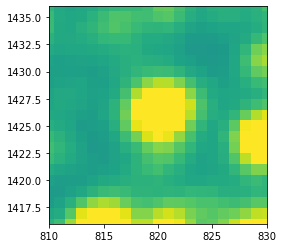

In [10]:


#Plot the xys on another image.

# First, get image submim and weight subim
imhdul = fits.open(imfnames[6])
im = imhdul[1].data

whdul = fits.open(wfnames[6])
w = whdul[1].data

# Get pixel coordinates for image
radec = (270.31177, -28.776405) # Repasted from above because I forgot

ws = wcs.WCS(imhdul[1].header)  # create a wcs object with the quadrant object's header
xy = ws.wcs_world2pix(np.array([[radec[0], radec[1]]]), 0)  # return the Ra/Dec positions as a numpy array

x = xy[0][0]
y = xy[0][1]

# print(xy)

#  Make the tile for image with xlim
xmin, xmax, ymin, ymax = int(x - s), int(x + s), int(y - s), int(y + s)

plt.imshow(im, vmin = -1600, vmax = 1600)
plt.scatter(x, y)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()


# Make the tile for image with indexing
sub = np.flipud(im[ymin:ymax, xmin:xmax])
weight = np.flipud(w[ymin:ymax, xmin:xmax])

xrel_ = x - xmin
yrel_ = y - ymin
# print(yrel_)
yrel_ = 2*s - yrel_-1

plt.imshow(sub, vmin = -1600, vmax = 1600)
# plt.scatter(x - xmin, 2*s - (y - ymin))
plt.scatter(xrel_, yrel_)
plt.show()


# Alright. Got correct tile. Now convert radecs to pixels the same way you did above.
ws = wcs.WCS(imhdul[1].header)  # create a wcs object with the quadrant object's header
xy_ = ws.wcs_world2pix(np.transpose(np.array([radecs[0], radecs[1]])), 0)  # return the Ra/Dec positions as a numpy array

# print("xy_")
# print(xy_)
# print(x, y)

# ws = wcs.WCS(imhdul[1].header)  # create a wcs object with the quadrant object's header
# xy_ = ws.wcs_world2pix(np.array([[radec[0], radec[1]]]), 0)  # return the Ra/Dec positions as a numpy array

xy_ = np.transpose(xy_)

x = xy_[0]
y = xy_[1]

# print(x, y)
# print(xmin, ymin)
# print(x - xmin, y - ymin)

xrel = x - xmin
yrel = y - ymin
#yrel = 2*s - yrel-1
#xrel = 2*s - xrel - 1
dec = yrel - yrel.astype(int)
rec = 1 - dec

lint = abs(yrel - yrel_)
diffy = min(lint)
index = list(lint).index(diffy)
diffy = (yrel - yrel_)[index]

lint = abs(xrel - xrel_)
diffx = min(lint)
index = list(lint).index(diffx)
diffx = (xrel - xrel_)[index]


#Plot it
plt.imshow(sub, vmin = -1600, vmax = 1600)
plt.scatter(xrel, yrel, alpha = 0.5)
plt.scatter(xrel_, yrel_, alpha = 0.5)
plt.xlim(xrel_ - 5, xrel_ + 5)
plt.ylim(yrel_ - 5, yrel_ + 5)
plt.show()
print(radec, radecs)
print("fluffy")
# print(xy)
# print(xy_)

# Hmmm. Plot the x and ys with xlim

plt.imshow(im, vmin = -1600, vmax = 1600)
#plt.scatter(x, y)
plt.scatter(xy[0][1], xy[0][0])
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

Some positions within 0.01 pix of edge of image clipped back to 0.01 pix inside image.
Fewer than 5 stars accepted in image, keeping original PSF
Iteration 1, median sky   0.00
Fewer than 5 stars accepted in image, keeping original PSF
Iteration 2, median sky  21.29
Fewer than 5 stars accepted in image, keeping original PSF
Iteration 3, median sky  37.66
Fewer than 5 stars accepted in image, keeping original PSF
Iteration 4, median sky  49.11
forced image


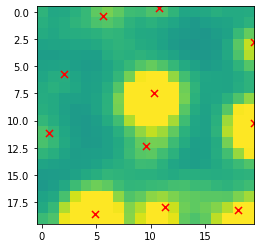

forced model image


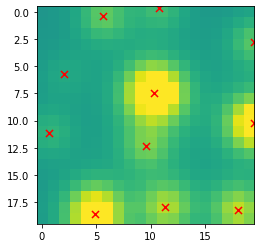

forced difference image


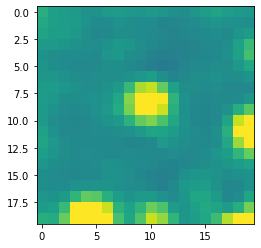

In [11]:
# Run forced crowdsource on this image

# Crowdsource on Reference Image

#MAKE PSF OBJECT
psf__ = psf.MoffatPSF(4, beta=3)
    
#CROWDSOURCE GET XS AND YS
pars_ = crowdsource_base.fit_im_force(sub, 
                                 yrel, xrel, 
                                 psf__, weight = weight, psfderiv = False, derivcentroids=False, refit_psf=True, refit_sky = True, startsky = 0) # Do the forced fit
    

print("forced image")
plt.imshow(subim, vmin=-1600, vmax=1600 )
plt.scatter(xrel, yrel, s=50, color = "red", alpha = 1, marker = "x")
plt.show()

print("forced model image")
plt.imshow(pars_[1], vmin=-1600, vmax=1600 )
plt.scatter(pars_[0]["y"], pars_[0]["x"], s=50, color = "red", alpha = 1, marker = "x")
plt.show()

print("forced difference image")
plt.imshow(subim - pars_[1], vmin=-1600, vmax=1600 )
plt.show()

In [ ]:
# I think it looks good/alright? There is some dipole-ing but don't know what to do about that yet.
# Plotting other images:

for i in range(len(imfnames[:10])):
    imhdul = fits.open(imfnames[i])
    whdul = fits.open(wfnames[i])


    q = Quadrant(imhdul, (64, 64)) # start a tile
    xy = q.get_xy_from_radec(np.array([[radec[0], radec[1]]])) # convert radec to pixel values


    # PLOT QUADRANT IMAGE
    subim, ymin, ymax, xmin, xmax = q.get_centered_im(radec[0], radec[1]) # Get the image centered on the int near radect
    plt.imshow(subim, vmin=-1600, vmax=1600)


    # Run forced crowdsource on this image

    # Crowdsource on Reference Image
    x = pars[0]["x"]
    y = pars[0]["y"]

    #MAKE PSF OBJECT
    psf__ = psf.MoffatPSF(4, beta=3)

    #CROWDSOURCE GET XS AND YS
    pars_ = crowdsource_base.fit_im_force(subim, 
                                     x, y, 
                                     psf__, weight = weight, psfderiv = False, derivcentroids=False, refit_psf=True, refit_sky = False, startsky = 0) # Do the forced fit
    
    print("forced difference image 1")
    plt.imshow(subim - pars_[1], vmin=-1600, vmax=1600 )
    plt.show()